In [1]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [3]:
import shutil

source = 'vision/references/detection/utils.py'
destination = './'

shutil.copy(source, destination)

'./utils.py'

In [5]:
import shutil

source = 'vision/references/detection/transforms.py'
destination = './'

shutil.copy(source, destination)

'./transforms.py'

In [7]:
source = 'vision/references/detection/coco_eval.py'
destination = './'

shutil.copy(source, destination)

'./coco_eval.py'

In [9]:
source = 'vision/references/detection/engine.py'
destination = './'

shutil.copy(source, destination)

'./engine.py'

In [11]:
source = 'vision/references/detection/coco_utils.py'
destination = './'

shutil.copy(source, destination)

'./coco_utils.py'

In [9]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [11]:
# defining the files directory and testing directory
files_dir = 'images/train'
test_dir = 'images/val'


class PeopleDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'person']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = PeopleDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  420 

(224, 224, 3) 
 {'boxes': tensor([[  0.0000, 117.6000,   8.7500, 168.9333]]), 'labels': tensor([1]), 'area': tensor([449.1667]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


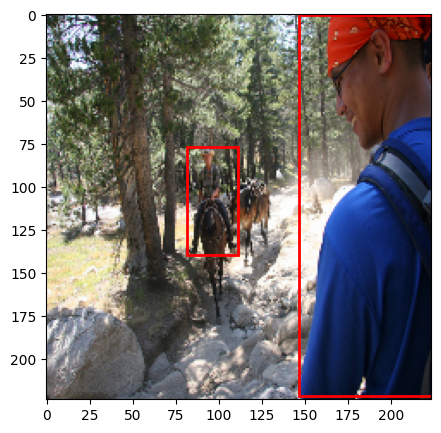

In [13]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

In [15]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [17]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [43]:
# use our dataset and defined transformations
dataset = PeopleDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = PeopleDataset(test_dir, 480, 480, transforms= get_transform(train=False))


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [49]:
# to train on gpu if selected.
device = torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [51]:
# training for 100 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/53]  eta: 0:16:59  lr: 0.000101  loss: 1.4791 (1.4791)  loss_classifier: 0.6762 (0.6762)  loss_box_reg: 0.6185 (0.6185)  loss_objectness: 0.1434 (0.1434)  loss_rpn_box_reg: 0.0410 (0.0410)  time: 19.2402  data: 0.3622
Epoch: [0]  [10/53]  eta: 0:12:18  lr: 0.001062  loss: 1.2699 (1.1917)  loss_classifier: 0.5883 (0.5359)  loss_box_reg: 0.4881 (0.4855)  loss_objectness: 0.1086 (0.1365)  loss_rpn_box_reg: 0.0324 (0.0338)  time: 17.1677  data: 0.2341
Epoch: [0]  [20/53]  eta: 0:09:46  lr: 0.002022  loss: 0.9013 (1.0315)  loss_classifier: 0.3436 (0.4275)  loss_box_reg: 0.4404 (0.4592)  loss_objectness: 0.0967 (0.1165)  loss_rpn_box_reg: 0.0236 (0.0283)  time: 17.6999  data: 0.2256
Epoch: [0]  [30/53]  eta: 0:06:56  lr: 0.002983  loss: 0.7794 (0.9279)  loss_classifier: 0.2477 (0.3567)  loss_box_reg: 0.4344 (0.4475)  loss_objectness: 0.0649 (0.0968)  loss_rpn_box_reg: 0.0214 (0.0269)  time: 18.5932  data: 0.2269
Epoch: [0]  [40/53]  eta: 0:03:53  lr: 0.003943  loss: 0.6600 (0

In [66]:
torch.save(model.state_dict(), 'faster_rcnn_MobileNET.pth')

In [68]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [76]:
img

tensor([[[0.0974, 0.0941, 0.0941,  ..., 0.8941, 0.8922, 0.8902],
         [0.0941, 0.0909, 0.0936,  ..., 0.8909, 0.8889, 0.8869],
         [0.1024, 0.1001, 0.1019,  ..., 0.8869, 0.8840, 0.8858],
         ...,
         [0.3307, 0.3466, 0.3638,  ..., 0.5404, 0.5456, 0.5551],
         [0.3104, 0.3336, 0.3530,  ..., 0.5359, 0.5444, 0.5431],
         [0.3007, 0.3255, 0.3438,  ..., 0.5229, 0.5314, 0.5301]],

        [[0.0582, 0.0549, 0.0549,  ..., 0.9412, 0.9392, 0.9373],
         [0.0549, 0.0516, 0.0544,  ..., 0.9379, 0.9360, 0.9340],
         [0.0660, 0.0637, 0.0655,  ..., 0.9340, 0.9311, 0.9329],
         ...,
         [0.2242, 0.2362, 0.2477,  ..., 0.4469, 0.4521, 0.4616],
         [0.2124, 0.2317, 0.2406,  ..., 0.4340, 0.4425, 0.4411],
         [0.2026, 0.2235, 0.2314,  ..., 0.4209, 0.4294, 0.4281]],

        [[0.0503, 0.0471, 0.0471,  ..., 1.0000, 1.0000, 1.0000],
         [0.0471, 0.0438, 0.0465,  ..., 1.0000, 0.9984, 0.9967],
         [0.0497, 0.0474, 0.0492,  ..., 0.9967, 0.9938, 0.

In [78]:
# pick one image from the test set
img, target = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  3


EXPECTED OUTPUT


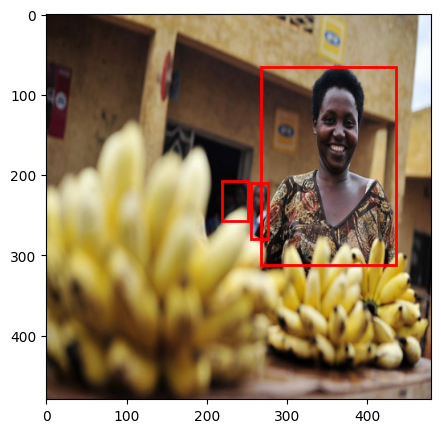

In [80]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


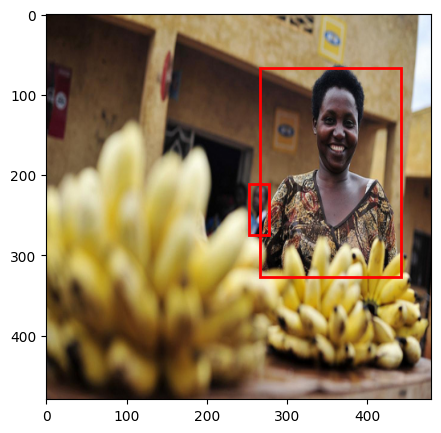

In [72]:
# Memeriksa apakah menggunakan GPU atau CPU
if isinstance(prediction, dict):
    # Jika `prediction` adalah dictionary, kita perlu memeriksa setiap nilai di dalamnya
    prediction_cpu = {}
    for key, value in prediction.items():
        if isinstance(value, torch.Tensor):
            # Jika nilai adalah tensor, kita pindahkan ke CPU
            prediction_cpu[key] = value.cpu()
        else:
            # Jika nilai bukan tensor, kita biarkan seperti adanya
            prediction_cpu[key] = value
elif isinstance(prediction, torch.Tensor):
    # Jika `prediction` adalah tensor tunggal, kita pindahkan langsung ke CPU
    prediction_cpu = prediction.cpu()
else:
    # Jika `prediction` bukan dictionary maupun tensor, biarkan seperti adanya
    prediction_cpu = prediction

# Sekarang Anda dapat menggunakan fungsi numpy
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction_cpu)

EXPECTED OUTPUT



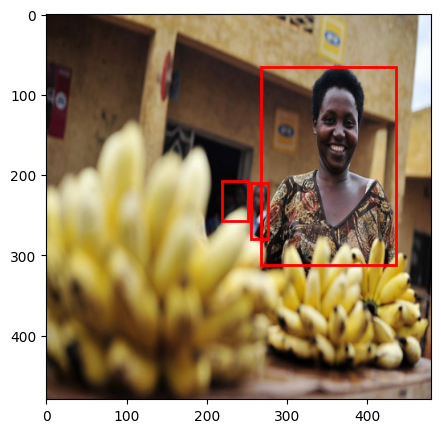

MODEL OUTPUT



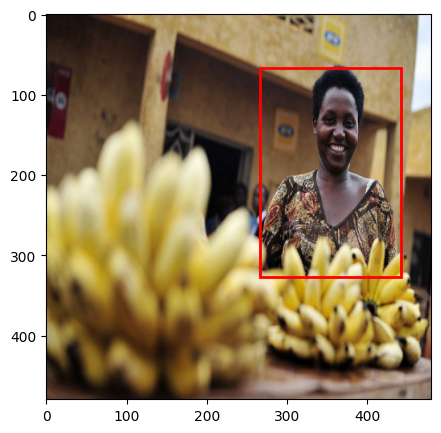

In [74]:
# Terapkan NMS pada hasil prediksi
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

# Pindahkan hasil NMS ke CPU jika berada di perangkat CUDA (GPU)
if isinstance(nms_prediction, dict):
    # Jika `nms_prediction` adalah dictionary, kita perlu memeriksa setiap nilai di dalamnya
    nms_prediction_cpu = {}
    for key, value in nms_prediction.items():
        if isinstance(value, torch.Tensor):
            # Jika nilai adalah tensor, kita pindahkan ke CPU
            nms_prediction_cpu[key] = value.cpu()
        else:
            # Jika nilai bukan tensor, kita biarkan seperti adanya
            nms_prediction_cpu[key] = value
elif isinstance(nms_prediction, torch.Tensor):
    # Jika `nms_prediction` adalah tensor tunggal, kita pindahkan langsung ke CPU
    nms_prediction_cpu = nms_prediction.cpu()
else:
    # Jika `nms_prediction` bukan dictionary maupun tensor, biarkan seperti adanya
    nms_prediction_cpu = nms_prediction

# Sekarang Anda dapat menggunakan fungsi numpy
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
plot_img_bbox(torch_to_pil(img), nms_prediction_cpu)